In this notebook, much of the code is built on top of the starter code provided in Stanford CS229 (Autumn 2017), and some is drawn from Andrew's another course, i.e., Coursera's Deep Learning Specialization and/or Stanford CS230. I think the starter code attempts to implement the algorithm by stacking training examples in rows (see the "nn_starter.py" file), but I follow the practice in class/lecture notes and stack training examples in columns in my own implementations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Some helper functions
def readData(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')
    return x, y

def nn_test(data, labels, params):
    h, output, cost = forward_prop(data, labels, params)
    output = output.T
    accuracy = compute_accuracy(output, labels)
    return cost, accuracy

def compute_accuracy(output, labels):
    accuracy = (np.argmax(output,axis=1) == np.argmax(labels,axis=1)).sum() * 1. / labels.shape[0]
    return accuracy

def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels

In [2]:
np.random.seed(100)
trainData, trainLabels = readData('images_train.csv', 'labels_train.csv')
trainLabels = one_hot_labels(trainLabels)
p = np.random.permutation(60000)
trainData = trainData[p,:]
trainLabels = trainLabels[p,:]

devData = trainData[0:10000,:]
devLabels = trainLabels[0:10000,:]
trainData = trainData[10000:,:]
trainLabels = trainLabels[10000:,:]

mean = np.mean(trainData)
std = np.std(trainData)
trainData = (trainData - mean) / std
devData = (devData - mean) / std

testData, testLabels = readData('images_test.csv', 'labels_test.csv')
testLabels = one_hot_labels(testLabels)
testData = (testData - mean) / std

Note that $$softmax(x)_i = \frac{\exp(x_i)}{\sum_{j=1}^K\exp(x_j)} = \frac{\exp(x_i)\cdot\exp(-C)}{\sum_{j=1}^K\exp(x_j)\cdot\exp(-C)} = \frac{\exp(x_i-C)}{\sum_{j=1}^K\exp(x_j-C)}$$
for any $C$. By picking $$C = \max_{k = 1, \cdots, K}x_k$$
we only need to take exponentiation of non-positive numbers (since $x_i - C \leq 0$ for all $i$), so numerical overflow can be avoided.

In [3]:
def softmax(x):
    """
    Compute softmax function for input. 
    Use tricks from previous assignment to avoid overflow
    """
    ### YOUR CODE HERE
    
    C = np.max(x, axis = 0, keepdims = True)
    x -= C
    x = np.exp(x)
    s = x / np.sum(x, axis = 0, keepdims = True)
    
    ### END YOUR CODE
    return s

def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    """
    ### YOUR CODE HERE
    
    s = 1 / (1 + np.exp(-x))
    
    ### END YOUR CODE
    return s

**Forward Propagation**:

\begin{eqnarray}
Z^{[1]} &=&  W^{[1]} X + b^{[1]} \\
h &=& \sigma(Z^{[1]}) \\
Z^{[2]} &=& W^{[2]} h + b^{[2]} \\
\hat{y} &=& softmax(Z^{[2]})
\end{eqnarray}

Then, we compute the cost $J_{MB}$ as follows: 
$$J_{MB} = - \frac{1}{B} \sum\limits_{i = 1}^{B} \sum\limits_{k = 1}^{K} y_k^{(i)}\log \hat{y}_k^{(i)}$$
When $B = m$, it becomes the cost over all $m$ examples.

In [4]:
def forward_prop(data, labels, params):
    """
    return hidder layer, output(softmax) layer and loss
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    ### YOUR CODE HERE
    
    B = data.shape[0]   # B is batch or mini batch size
    
    X = data.T     # data.shape = (B, n_x), labels.shape = (B, 10)
    Y = labels.T   # But more convenient to stack features(x_i's) and labels(y_i's) in columns
    
    # Forward propagation
    Z1 = np.dot(W1, X) + b1
    h = sigmoid(Z1)
    Z2 = np.dot(W2, h) + b2
    y = softmax(Z2)
    
    # Compute cost
    logprobs = Y * np.log(y)
    cost = -1/B * np.sum(logprobs)
    
    ### END YOUR CODE
    return h, y, cost

We denote the gradient of the cost function $J$ with respect to some parameter $var$ by $dvar$, i.e., $dvar = \frac{\partial J}{\partial var}$. Here is a summary of (vectorized) gradient descent.
\begin{eqnarray}
dZ^{[2]} &=& \hat{y} - y \\
dW^{[2]} &=& \frac{1}{B} dZ^{[2]} h^T + \lambda W^{[2]}\\
db^{[2]} &=& \frac{1}{B} np.sum(dZ^{[2]}, axis = 1, keepdims = True) \\
dZ^{[1]} &=& W^{[2]T} dZ^{[2]} * g^{[1]'}(Z^{[1]}) \\
dW^{[1]} &=& \frac{1}{B} dZ^{[2]} X^T + \lambda W^{[1]}\\
db^{[1]} &=& \frac{1}{B} np.sum(dZ^{[1]}, axis = 1, keepdims = True)
\end{eqnarray}
Here, $B$ denotes the mini batch size, while $\lambda$ denotes the regularization parameter.

- To compute dZ1, we need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(\cdot)$ is the sigmoid activation function, if $h = g^{[1]}(z)$ then $g^{[1]'}(z) = h (1-h)$. Therefore, we can compute $g^{[1]'}(Z^{[1]})$ using `h * (1 - h)`.

In [5]:
def backward_prop(data, labels, params, lambd):
    """
    return gradient of parameters
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    ### YOUR CODE HERE
    
    # B is mini batch size
    B = data.shape[0]
    
    # Stack features and labels in columns (by taking transpose)
    X = data.T
    Y = labels.T
    
    # Get the activation values of hidden & output layers, but cost is not needed in backprop
    h, y, _ = forward_prop(data, labels, params)
    
    # Compute gradients
    gradZ2 = y - Y
    gradW2 = 1/B * np.dot(gradZ2, h.T) + lambd * W2
    gradb2 = 1/B * np.sum(gradZ2, axis = 1, keepdims = True)
    gradZ1 = np.dot(W2.T, gradZ2) * (h * (1 - h))
    gradW1 = 1/B * np.dot(gradZ1, X.T) + lambd * W1
    gradb1 = 1/B * np.sum(gradZ1, axis = 1, keepdims = True)
    
    ### END YOUR CODE

    grad = {}
    grad['W1'] = gradW1
    grad['W2'] = gradW2
    grad['b1'] = gradb1
    grad['b2'] = gradb2

    return grad

In [6]:
def update_parameters(params, grad, learning_rate):
    """
    Updates parameters using the gradient descent update rule
    
    Arguments:
    params -- python dictionary containing your parameters
    grad -- python dictionary containing your gradients
    
    Returns:
    params -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "params"
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    
    # Retrieve each gradient from the dictionary "grad"
    gradW1 = grad["W1"]
    gradb1 = grad["b1"]
    gradW2 = grad["W2"]
    gradb2 = grad["b2"]
    
    # Update rule for each parameter
    W1 -= learning_rate * gradW1
    b1 -= learning_rate * gradb1
    W2 -= learning_rate * gradW2
    b2 -= learning_rate * gradb2
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2}
    
    return params

In [7]:
def nn_train(trainData, trainLabels, devData, devLabels, lambd = 0):
    (m, n) = trainData.shape
    num_hidden = 300
    learning_rate = 5
    params = {}

    ### YOUR CODE HERE
    
    # Create some useful variables
    num_epochs = 30   # number of epochs
    B = 1000   # mini batch size
    num_iterations = m // B   # number of iterations per epoch
    K = trainLabels.shape[1]   # K = 10 classes
    
    # To save the cost values and accuracies at the end of each epoch
    trainCost = np.zeros((num_epochs, 1))
    trainAccuracy = np.zeros((num_epochs, 1))
    devCost = np.zeros((num_epochs, 1))
    devAccuracy = np.zeros((num_epochs, 1))
    
    # Initialize the parameters
    np.random.seed(229)
    params["W1"] = np.random.randn(num_hidden, n)
    params["b1"] = np.zeros((num_hidden, 1))
    params["W2"] = np.random.randn(K, num_hidden)
    params["b2"] = np.zeros((K, 1))
    
    for i in range(num_epochs):
        
        for j in range(num_iterations):
            
            # Set up the mini batch of training data during iteration j
            start = j * B
            end = (j+1) * B
            data = trainData[start:end, :]
            labels = trainLabels[start:end, :]
            
            # Use backprop to compute gradients, and update the parameters by gradient descent
            grad = backward_prop(data, labels, params, lambd)
            params = update_parameters(params, grad, learning_rate)
        
        # For each epoch, record the cost and accuracy over training and dev sets
        trainCost[i], trainAccuracy[i] = nn_test(trainData, trainLabels, params)
        devCost[i], devAccuracy[i] = nn_test(devData, devLabels, params)
                    
    ### END YOUR CODE

    return params, trainCost, trainAccuracy, devCost, devAccuracy

In [8]:
params, trainCost, trainAccuracy, devCost, devAccuracy = nn_train(trainData, trainLabels, devData, devLabels)

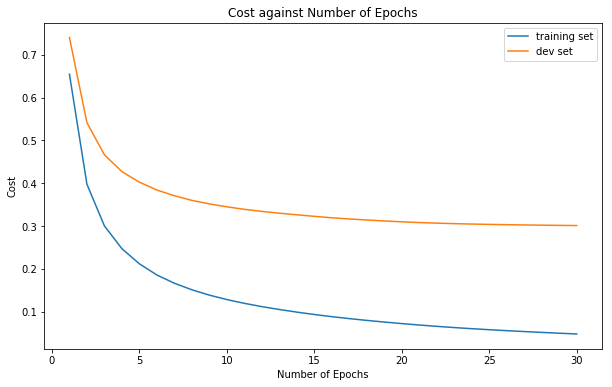

In [9]:
num_epochs = trainCost.shape[0]

fig = plt.figure(1, figsize = (10,6))

# Plot the value of cost function against the number of epochs
plt.plot(range(1, num_epochs + 1), trainCost, label='training set')
plt.plot(range(1, num_epochs + 1), devCost, label='dev set')

# Other settings
plt.xlabel('Number of Epochs')
plt.ylabel('Cost')
plt.title('Cost against Number of Epochs')
plt.legend(loc = 'upper right')
plt.show()

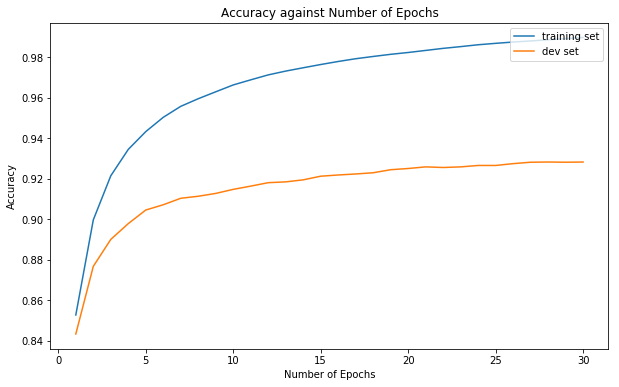

In [10]:
num_epochs = trainCost.shape[0]

fig = plt.figure(1, figsize = (10,6))

# Plot the value of cost function against the number of epochs
plt.plot(range(1, num_epochs + 1), trainAccuracy, label='training set')
plt.plot(range(1, num_epochs + 1), devAccuracy, label='dev set')

# Other settings
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy against Number of Epochs')
plt.legend(loc = 'upper right')
plt.show()

In [11]:
with open('params_without_regularization.pkl', 'wb') as fp:
    pickle.dump(params, fp)

###################################################################################################################

In [12]:
params_reg, trainCost, trainAccuracy, devCost, devAccuracy = nn_train(trainData, trainLabels, devData, devLabels, lambd = 0.0001)

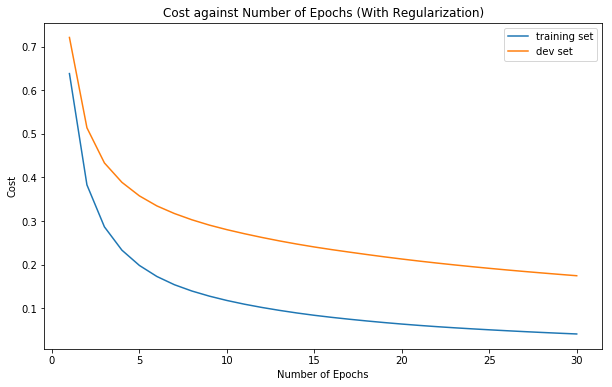

In [13]:
num_epochs = trainCost.shape[0]

fig = plt.figure(1, figsize = (10,6))

# Plot the value of cost function against the number of epochs
plt.plot(range(1, num_epochs + 1), trainCost, label='training set')
plt.plot(range(1, num_epochs + 1), devCost, label='dev set')

# Other settings
plt.xlabel('Number of Epochs')
plt.ylabel('Cost')
plt.title('Cost against Number of Epochs (With Regularization)')
plt.legend(loc = 'upper right')
plt.show()

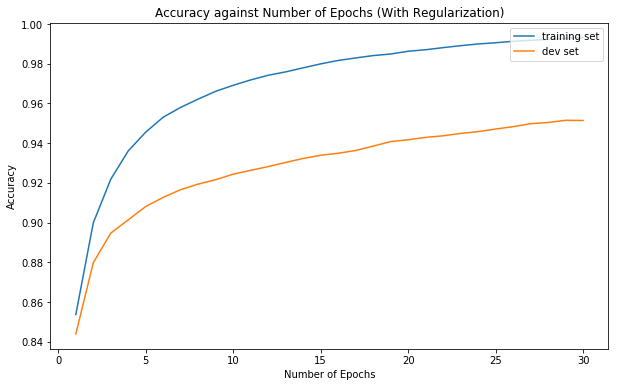

In [14]:
num_epochs = trainCost.shape[0]

fig = plt.figure(1, figsize = (10,6))

# Plot the value of cost function against the number of epochs
plt.plot(range(1, num_epochs + 1), trainAccuracy, label='training set')
plt.plot(range(1, num_epochs + 1), devAccuracy, label='dev set')

# Other settings
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy against Number of Epochs (With Regularization)')
plt.legend(loc = 'upper right')
plt.show()

In [15]:
with open('params_with_regularization.pkl', 'wb') as fp:
    pickle.dump(params_reg, fp)

Summary:
Without regularization, there are large differences between performances of the model on the training set and on the dev set (in terms of both cost values and accuracies), this indicates the problem of high variance. On the other hand, with regularization, the gaps between performances (cost values and accuracies) become smaller, and this suggests that regularization helps with the problem of high variance. Moreover, the model with regularization achieves a lower cost and a higher accuracy on the dev set than the model without regularization, so it is a sign that regularization makes the model generalize better.

###################################################################################################################

In [16]:
with open('params_without_regularization.pkl', 'rb') as fp:
    params = pickle.load(fp)
with open('params_with_regularization.pkl', 'rb') as fp:
    params_reg = pickle.load(fp)

In [17]:
readyForTesting = True
if readyForTesting:
    _, accuracy = nn_test(testData, testLabels, params)
print ('Test accuracy without regularization: %f' % accuracy)

Test accuracy without regularization: 0.933500


In [18]:
readyForTesting = True
if readyForTesting:
    _, accuracy = nn_test(testData, testLabels, params_reg)
print ('Test accuracy with regularization: %f' % accuracy)

Test accuracy with regularization: 0.952800
